In [29]:
# import dependencies

import sys
from dotenv import load_dotenv
import time

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


In [30]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

In [3]:
sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3

In [4]:
df = getDatasetV1(None)
df.drop(columns=['year', 'district'], inplace=True)
df.drop_duplicates(inplace=True)
df

,mean_temp,mean_total_snow,mean_total_rain,mean_snow_on_grnd,mean_total_precip,has_ergot
0,0.451735,0.303979,0.529384,6.005903,1.189348,False
1,4.239744,0.116534,0.328105,0.860822,0.871078,False
2,1.628772,0.155237,0.250507,3.564932,0.790694,True
3,3.060292,0.135583,0.332711,1.054999,1.299196,True
4,2.796575,0.010502,0.078265,0.010959,0.908037,True
...,...,...,...,...,...,...
1059,0.777808,0.000000,0.000000,14.356164,1.151507,True
1060,2.653288,0.000000,0.000000,6.519178,1.097808,True
1061,1.931507,0.000000,0.000000,5.945205,2.099726,True
1062,1.386849,0.000000,0.000000,5.210959,1.102466,True


In [5]:
df.columns

Index(['mean_temp', 'mean_total_snow', 'mean_total_rain', 'mean_snow_on_grnd',
       'mean_total_precip', 'has_ergot'],
      dtype='object')

In [6]:
# X = df.drop(columns=['incidence'])
# y = df['incidence'].astype(int)

X = df.drop(columns=['has_ergot'])
y = df['has_ergot'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversampling
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [21]:
model = Sequential()

layers_node = [32, 16, 32, 16, 8, 1]

for i in range(len(layers_node)):
    if i == 0:
        model.add(Dense(layers_node[i], activation='relu', input_dim=X_train.shape[1]))
    elif(i == len(layers_node) - 1):
        model.add(Dense(layers_node[i], activation='sigmoid'))
    else:
        model.add(Dense(layers_node[i], activation='relu'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                192       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 32)                544       
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,937
Trainable params: 1,937
Non-traina

In [23]:
history = model.fit(X_resampled, y_resampled, epochs=500, batch_size=32, validation_split=0.2)

Epoch 1/500


32/32 [==============================] - 1s 4ms/step - loss: 0.7000 - accuracy: 0.5015 - val_loss: 0.7184 - val_accuracy: 0.0824
Epoch 2/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.6273 - val_loss: 0.7758 - val_accuracy: 0.0078
Epoch 3/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.6254 - val_loss: 0.8688 - val_accuracy: 0.0000e+00
Epoch 4/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.6273 - val_loss: 0.9044 - val_accuracy: 0.0118
Epoch 5/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.6283 - val_loss: 0.9031 - val_accuracy: 0.0275
Epoch 6/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.6342 - val_loss: 0.9175 - val_accuracy: 0.0392
Epoch 7/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6283 - accuracy: 0.6342 - val_loss: 0.9121 - val_accuracy: 0.0549
Epoch 8/500
32/32 [==

In [24]:
y_log = model.predict(X_test)
time.sleep(2)
y_pred = np.where(y_log > 0.5, 1, 0)

1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 629us/step


In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score: ", auc_score)

print(classification_report(y_test, y_pred))

Accuracy:  0.7471264367816092
Precision:  0.8476190476190476
Recall:  0.839622641509434
F1 Score:  0.8436018957345972
AUC Score:  0.5932807085098191
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        49
           1       0.85      0.84      0.84       212

    accuracy                           0.75       261
   macro avg       0.59      0.59      0.59       261
weighted avg       0.75      0.75      0.75       261



### plot

In [31]:
# def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     plt.title(title)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     plt.grid()
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt


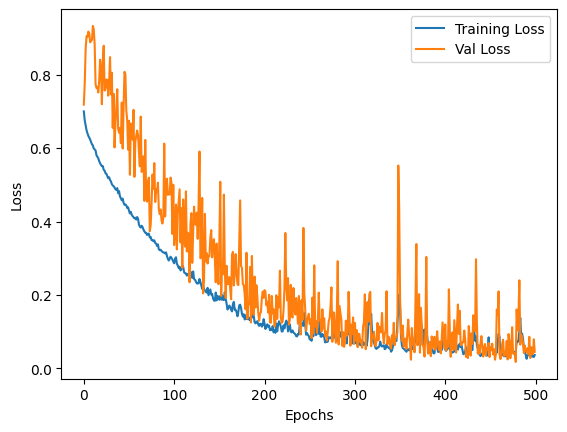

In [26]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

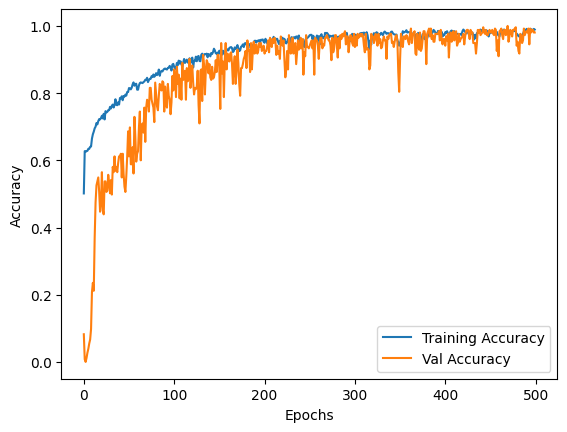

In [27]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

---
# datset v1
---
---
### 500 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.6917293233082706
    - Precision:  0.8009049773755657
    - Recall:  0.8232558139534883
    - F1 Score:  0.8119266055045871
    - AUC Score:  0.583076626877166
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.6954887218045113
    - Precision:  0.8130841121495327
    - Recall:  0.8093023255813954
    - F1 Score:  0.8111888111888111  
    - AUC Score:  0.598815941470928
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.7443609022556391
    - Precision:  0.8075313807531381
    - Recall:  0.8976744186046511
    - F1 Score:  0.8502202643171807
    - AUC Score:  0.5932807085098191
---

---
# datset v2
---
---
### 200 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.7568199532346064
    - Precision:  0.845703125
    - Recall:  0.8490196078431372
    - F1 Score:  0.847358121330724
    - AUC Score:  0.6692982456140351
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.77431906614786
    - Precision:  0.8287037037037037
    - Recall:  0.895
    - F1 Score:  0.8605769230769231 
    - AUC Score:  0.6216666666666668
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.8054474708171206
    - Precision:  0.8472222222222222
    - Recall:  0.915
    - F1 Score:  0.8798076923076923
    - AUC Score:  0.6567543859649123
---

---
# datset v3
---
---
### 500 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.754863813229572
    - Precision:  0.8549222797927462
    - Recall:  0.825
    - F1 Score:  0.8396946564885495
    - AUC Score:  0.5960299709237307
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.7272018706157444
    - Precision:  0.8609913793103449
    - Recall:  0.7833333333333333
    - F1 Score:  0.8203285420944558
    - AUC Score:  0.6184261537314546
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.6812159002338269
    - Precision:  0.8739290085679314
    - Recall:  0.7
    - F1 Score:  0.7773543821448012
    - AUC Score:  0.6299653321404608
---